<a href="https://colab.research.google.com/github/Maya7991/gsc_classification/blob/main/Net2_resnet_50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import torchvision.models as models
from torch import nn
from torchvision import transforms

from PIL import Image
import matplotlib.pyplot as plt

* input shape: (B, 3, H, W)
* outputs as patch-wise features of shape: (B, 49, output_dim) where 49 = 7 x 7
*  spatial grid (from ResNet’s output)
* output_dim = feature dimension (e.g., 512)


Net2 is a image feature extractor which uses pretrained ResNet-50 backbone

In [2]:
class Net2CNN(nn.Module):
    def __init__(self, output_dim=512):
        super(Net2CNN, self).__init__()
        base_model = models.resnet50(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(base_model.children())[:-2])  # (B, 2048, 7, 7)
        self.proj = nn.Conv2d(2048, output_dim, kernel_size=1)  # Reduce channels

    def forward(self, x):
        x = self.feature_extractor(x)  # (B, 2048, 7, 7)
        x = self.proj(x)              # (B, output_dim, 7, 7)
        x = x.flatten(2).transpose(1, 2)  # (B, 49, output_dim)
        return x


In [8]:
net2 = Net2CNN(output_dim=512)
net2.eval()
print()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])
])

# image = Image.open("image.jpg").convert("RGB")
PIL_image = Image.new('RGB', (224, 224), color = 'black')
img_tensor = transform(PIL_image).unsqueeze(0)  # (1, 3, 224, 224)

features = net2(img_tensor)  # shape: (1, 49, 512)
print(features.shape)

torch.Size([1, 49, 512])


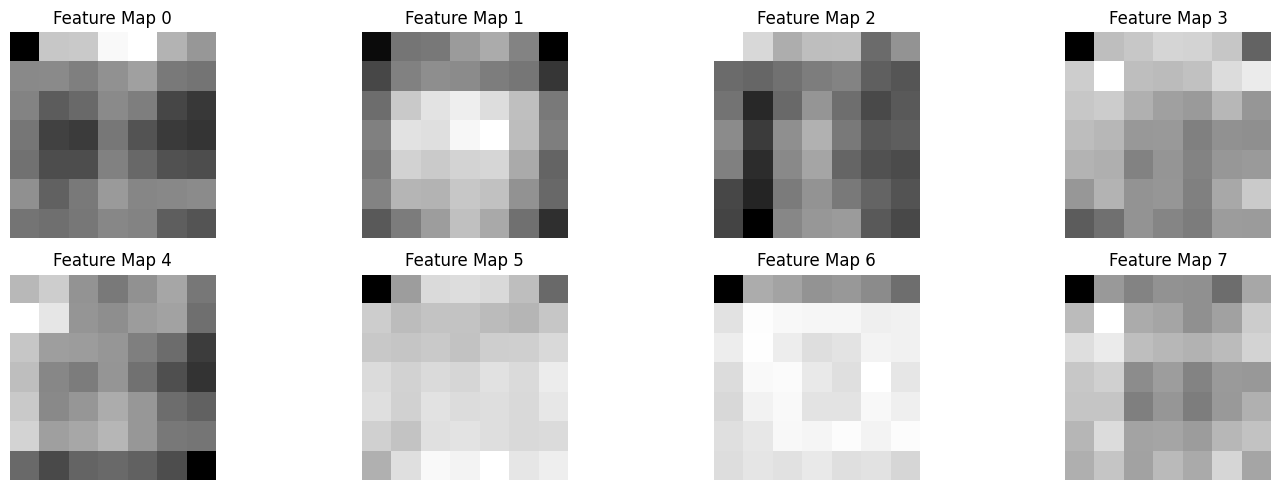

In [7]:
single_image_features = features[0]  # shape: (49, output_dim)

# Reshape the features back to a spatial grid (output_dim, 7, 7)
# We need to permute the dimensions from (49, output_dim) to (output_dim, 49) first
# and then reshape 49 into 7x7.
spatial_features = single_image_features.transpose(0, 1).reshape(-1, 7, 7) # shape: (output_dim, 7, 7)

# Convert to numpy for visualization
spatial_features_np = spatial_features.detach().numpy()

# Define how many feature maps to visualize
num_features_to_visualize = 8
output_dim = spatial_features_np.shape[0] # Get the actual output_dim

# Visualize a few feature maps
plt.figure(figsize=(15, 5))
for i in range(min(num_features_to_visualize, output_dim)):
    plt.subplot(2, 4, i + 1) # Adjust subplot grid based on num_features_to_visualize
    plt.imshow(spatial_features_np[i], cmap='gray')
    plt.title(f'Feature Map {i}')
    plt.axis('off')

plt.tight_layout()
plt.show()

# You can also visualize the original image (as numpy array) for comparison
# Convert the transformed image tensor back to numpy array and unnormalize (optional)
# img_np = img_tensor.squeeze(0).permute(1, 2, 0).detach().numpy()
# # Simple visualization without unnormalizing (might look weird)
# plt.figure()
# plt.imshow(img_np)
# plt.title("Input Image (Tensor as RGB)")
# plt.axis('off')
# plt.show()